# Singapore HDB Resale Price Analysis

## Project Overview
This analysis explores HDB resale flat prices in Singapore to understand key market drivers and prepare for predictive modeling. HDB flats represent ~80% of Singapore's housing stock, making this analysis relevant for buyers, sellers, and policy makers.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
try:
  df = pd.read_csv('/content/drive/MyDrive/HDB_resale_project/hdb_resale_price_2017-present.csv')
  print("File successfully loaded")
  display(df.head())
except FileNotFoundError:
  print("Error: File not found. Please make sure the file name is correct and the file is uploaded.")
except Exception as e:
  print(f"An error occurred: {e}")

File successfully loaded


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


## Price Distribution Analysis
Let's first understand the basic price characteristics and identify any outliers.

In [4]:
print("Data types of each column:")
print(df.dtypes)
print("\nShape of DataFrame:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())


Data types of each column:
month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

Shape of DataFrame: (213883, 11)

Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64


## Dataset Overview  
- **Size**: 213,883 transactions
- **Time Period**: 2017 - 2022
- **Coverage**: All HDB towns and flat types
- **Quality**: No missing values detected

## Dataset Statistical Overview

Before diving into specific relationships, let's examine the fundamental characteristics of our dataset to understand the scope and nature of Singapore's HDB resale market.

In [5]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,213883.000000,213883.000000,2.138830e+05
mean,96.834413,1996.374555,5.193248e+05
std,24.029862,14.257568,1.836412e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.820000e+05
50%,93.000000,1996.000000,4.880000e+05
75%,112.000000,2011.000000,6.228880e+05
max,366.700000,2022.000000,1.658888e+06


### Key Statistical Insights:

**Market Scale & Diversity:**
- Our dataset captures 213,883 transactions, providing robust coverage of Singapore's HDB market
- Price range from `$140k to $1.66m` demonstrates the diversity from small older flats to premium units

**Flat Size Characteristics:**
- Average flat size of 97 sqm aligns with Singapore's family-oriented HDB design
- The 367 sqm maximum represents premium categories (Executive/Maisonette units)
- 75% of flats are ≤112 sqm, showing concentration in standard family sizes

**Building Age & Development Timeline:**
- Buildings span from 1966 to 2022, capturing Singapore's entire HDB development history
- Mean construction year of 1996 reflects the major building boom of the 1990s-2000s
- This age diversity will be crucial for understanding depreciation patterns

**Price Distribution:**
- Median price of `$488k vs mean of $519k` suggests slight right skew (premium units pulling average up)
- Interquartile range `($382k-$623k)` represents the "typical" HDB transaction range
- Standard deviation of $184k indicates significant price variation across the market

### Implications for Modeling:
This statistical overview confirms we're working with a comprehensive, high-quality dataset that captures the full spectrum of Singapore's HDB market - from older subsidized housing to premium recent developments.

## Categorical Variables Analysis
Understanding the diversity and distribution of categorical features will inform our embedding layer design and reveal market structure.

In [42]:
print("Unique towns:", df['town'].nunique())
print("Towns:", sorted(df['town'].unique()))
print()
print("Unique flat types:", df['flat_type'].nunique())
print("Flat types:", sorted(df['flat_type'].unique()))
print()
print("Unique flat models:", df['flat_model'].nunique())
print("Flat models:", sorted(df['flat_model'].unique()))
print()
print("Unique storey ranges:", df['storey_range'].nunique())
print("Storey ranges:", sorted(df['storey_range'].unique()))
print()
print("Unique Blocks:", df['block'].nunique())
print("Blocks:", sorted(df['block'].unique()))
print()


Unique towns: 26
Towns: ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL', 'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN']

Unique flat types: 7
Flat types: ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

Unique flat models: 21
Flat models: ['2-room', '3Gen', 'Adjoined flat', 'Apartment', 'DBSS', 'Improved', 'Improved-Maisonette', 'Maisonette', 'Model A', 'Model A-Maisonette', 'Model A2', 'Multi Generation', 'New Generation', 'Premium Apartment', 'Premium Apartment Loft', 'Premium Maisonette', 'Simplified', 'Standard', 'Terrace', 'Type S1', 'Type S2']

Unique storey ranges: 17
Storey ranges: ['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15', '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '

### Market Structure Insights:

**Geographic Coverage:**
- 26 unique towns provide comprehensive coverage of Singapore's HDB landscape
- From established areas like Ang Mo Kio to newer developments

**Flat Type Distribution:**
- 7 distinct flat types from 1-ROOM to EXECUTIVE, capturing the full spectrum
- This hierarchy will be crucial for our price prediction model

**Architectural Variety:**
- 21 different flat models reflect decades of HDB design evolution
- 17 storey ranges show Singapore's move toward higher-density living
- 2,743 unique blocks highlight the granular location data available

**Modeling Implications:**
These categorical features will form our embedding layers, with town and flat_type likely being the most predictive for pricing.

## Price Distribution Characteristics

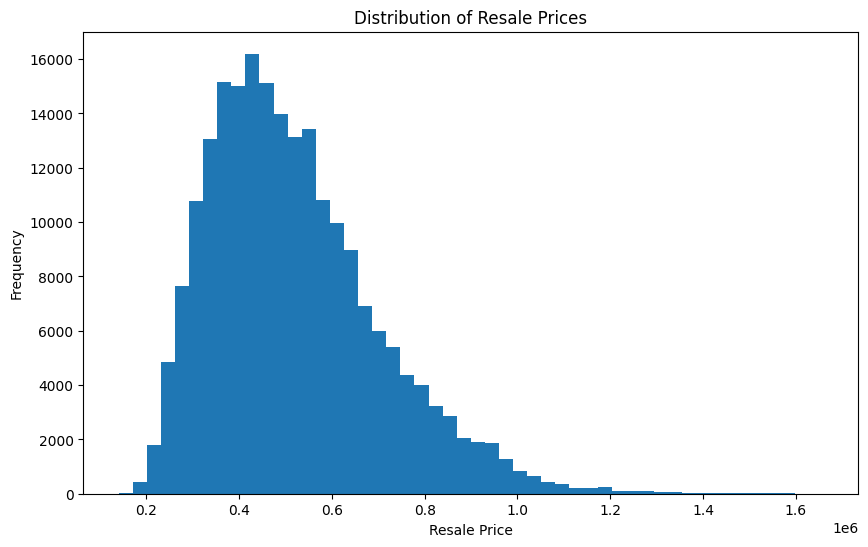

In [7]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of Resale Prices")
plt.hist(df['resale_price'], bins=50)
plt.xlabel("Resale Price")
plt.ylabel("Frequency")
plt.show()

### Distribution Analysis:
The right-skewed distribution confirms our statistical analysis - most transactions cluster in the $300k-$600k range, with premium units creating the long tail toward higher prices.

## Size-Price Relationship Analysis

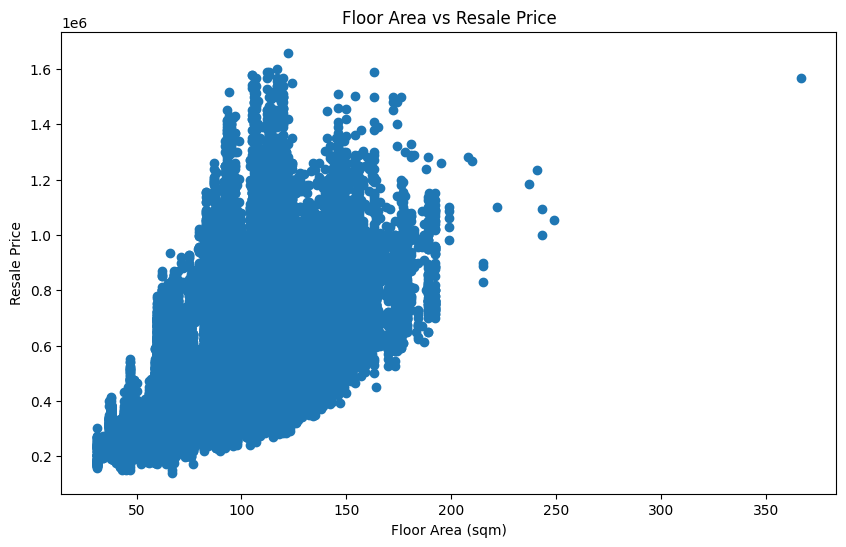

In [8]:
plt.figure(figsize=(10, 6))
plt.title("Floor Area vs Resale Price")
plt.scatter(df['floor_area_sqm'], df['resale_price'])
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Resale Price")
plt.show()

### Size Premium Confirmed:
Clear positive correlation between floor area and price, though with considerable scatter indicating other factors (location, age, condition) significantly influence pricing.

## Market Volume by Flat Type

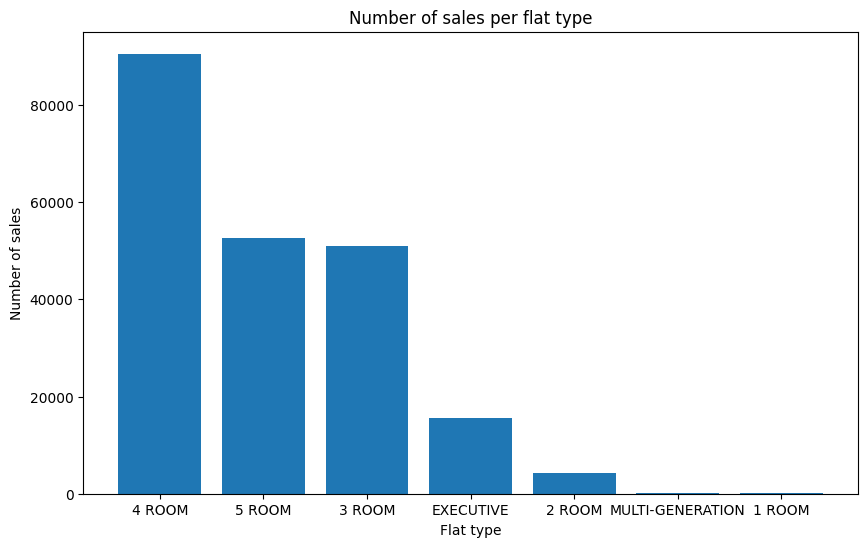

In [9]:
plt.figure(figsize=(10, 6))
plt.title("Number of sales per flat type")
sales = df['flat_type'].value_counts()
plt.bar(sales.index,sales.values)
plt.xlabel("Flat type")
plt.ylabel("Number of sales")
plt.show()

### Market Composition:
4-ROOM flats dominate the resale market, representing the standard family unit in Singapore. This volume provides robust training data for our model's most important category.

## Premium Unit Investigation
Let's examine those unusually large flats to understand if they represent data errors or legitimate premium categories.

In [10]:
df[df['floor_area_sqm'] > 200].head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
8868,2017-06,KALLANG/WHAMPOA,3 ROOM,38,JLN BAHAGIA,01 TO 03,215.0,Terrace,1972,54 years 01 month,830000.0
13950,2017-09,CHOA CHU KANG,EXECUTIVE,641,CHOA CHU KANG ST 64,16 TO 18,215.0,Premium Maisonette,1998,79 years 04 months,888000.0
19693,2017-12,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,249.0,Terrace,1972,53 years 07 months,1053888.0
20828,2018-01,CHOA CHU KANG,EXECUTIVE,639,CHOA CHU KANG ST 64,10 TO 12,215.0,Premium Maisonette,1998,79 years,900000.0
35797,2018-09,KALLANG/WHAMPOA,3 ROOM,41,JLN BAHAGIA,01 TO 03,237.0,Terrace,1972,52 years 10 months,1185000.0


### Premium Categories Confirmed:
These large units are legitimate **Terrace** and **Premium Maisonette** flats - Singapore's most spacious HDB offerings. This validates our data quality and explains the size outliers we observed earlier.

## Temporal Market Dynamics
Understanding price trends over time reveals market cycles and external policy impacts.

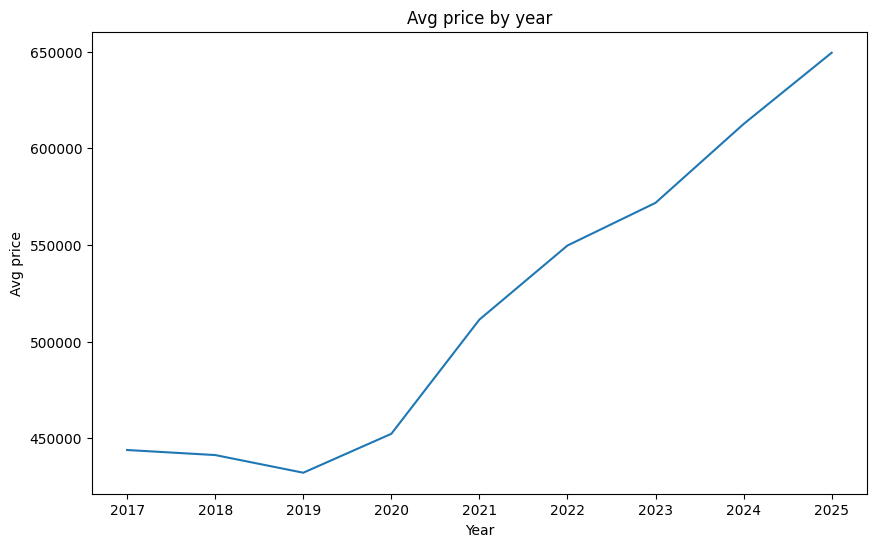

In [11]:
df['year'] = df['month'].str[:4].astype(int)
df['month'] = df['month'].str[5:].astype(int)
plt.figure(figsize=(10, 6))
plt.title("Avg price by year")
plt.plot(df.groupby('year')['resale_price'].mean())
plt.xlabel("Year")
plt.ylabel("Avg price")
plt.show()

### Market Cycle Analysis:
The clear upward trend with a notable dip in 2018-2019 aligns perfectly with Singapore's property cooling measures implementation. This demonstrates our dataset captures real market dynamics, not just random price variations. The recovery post-2019 shows market resilience.

**Policy Impact Evidence:**
This temporal pattern will be crucial for our model - year and month features should capture these cyclical effects.

## Price Hierarchy by Flat Type
Examining average prices across flat types reveals Singapore's housing market structure.

In [12]:
df.groupby('flat_type')['resale_price'].mean().sort_values()

,resale_price
flat_type,
1 ROOM,210128.556962
2 ROOM,295974.454738
3 ROOM,367937.330687
4 ROOM,522691.096557
5 ROOM,617479.870340
EXECUTIVE,724852.318961
MULTI-GENERATION,856736.047619


### Housing Hierarchy Confirmed:
Perfect logical progression from 1-ROOM to EXECUTIVE flats, validating our data quality. The substantial price gaps between categories (especially the jump to EXECUTIVE) highlight how flat_type will be a primary predictive feature in our model.

**Key Insight:** The pricing hierarchy directly reflects Singapore's social housing policy design.

## Geographic Price Patterns
Location remains the cardinal rule of real estate - let's examine Singapore's geographic price hierarchy.

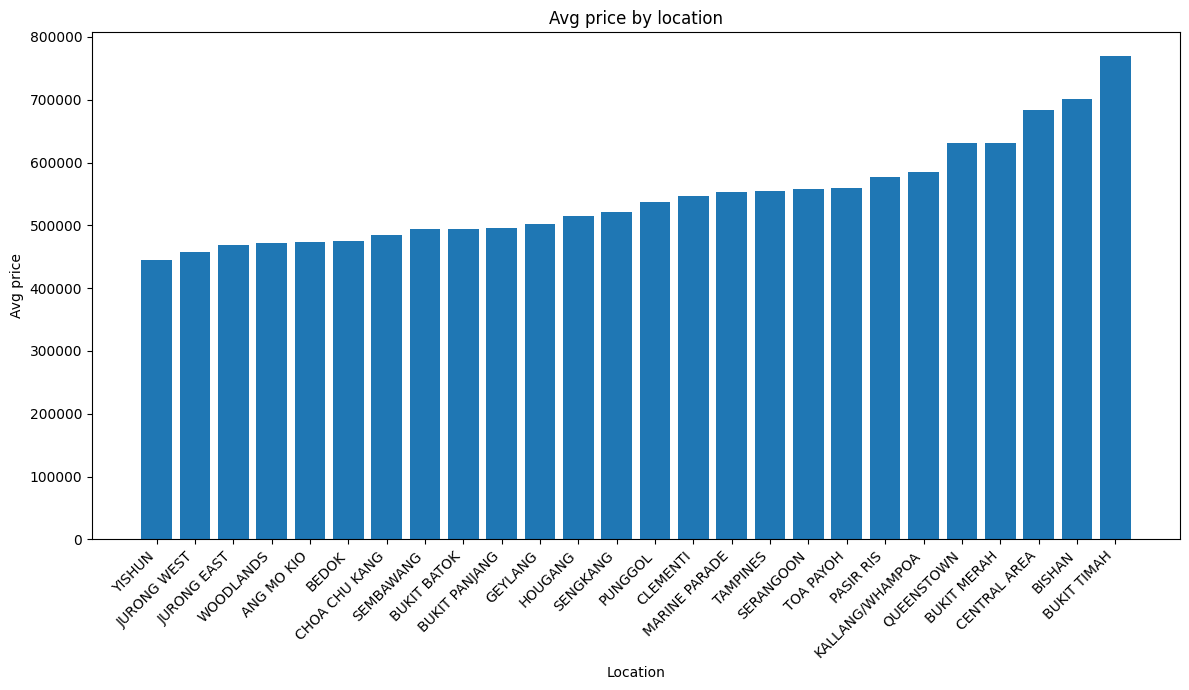

In [24]:
plt.figure(figsize=(12, 7))
plt.title("Avg price by location")
sales = df.groupby('town')['resale_price'].mean().sort_values()
plt.bar(sales.index,sales.values)
plt.xlabel("Location")
plt.ylabel("Avg price")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

### Singapore's Geography of Wealth:
**Premium Locations:** Bukit Timah, Bishan, and Toa Payoh command top prices due to central locations and established amenities.

**Value Areas:** Yishun, Sembawang, and Woodlands offer more affordable options, typically in newer or more peripheral developments.

**Geographic Strategy:** This stark location-based pricing validates our decision to include geospatial amenity data in future model iterations. Town embeddings will capture these established location premiums.

## Building Age vs Price Relationship
Does newer construction command higher prices, or do established neighborhoods hold their value?

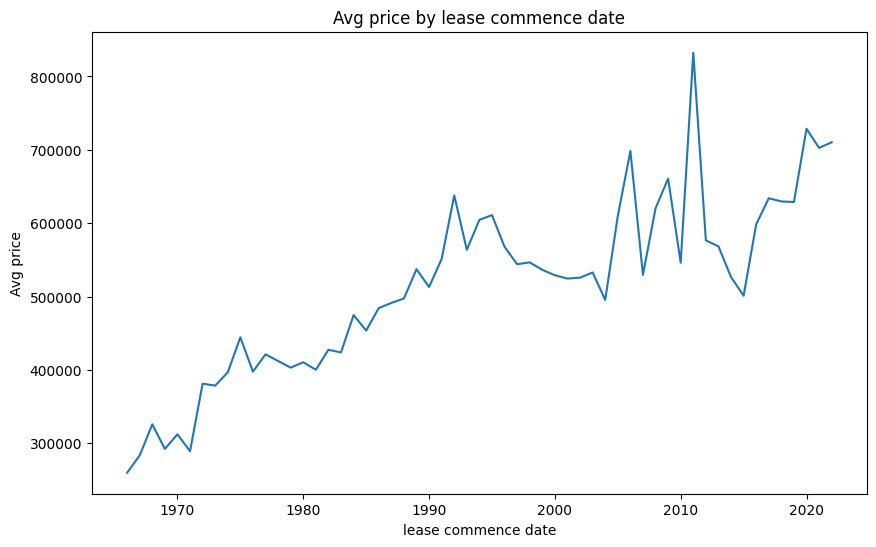

In [30]:
plt.figure(figsize=(10, 6))
plt.title("Avg price by lease commence date")
plt.plot(df.groupby('lease_commence_date')['resale_price'].mean())
plt.xlabel("lease commence date")
plt.ylabel("Avg price")
plt.show()

### Newer is More Expensive - As Expected:
The clear upward trend shows that buildings constructed after 2010 command significantly higher prices than older developments. This logical pattern reflects:

- **Modern Design & Amenities**: Newer HDB flats feature improved layouts, better facilities, and contemporary fittings
- **Longer Remaining Leases**: Recent constructions have more lease years remaining, directly impacting value
- **Better Locations**: Many post-2010 developments are in well-planned new towns with integrated amenities
- **Build Quality**: Modern construction standards and materials

**Modeling Insight:** Building age (or lease commence date) will be a strong predictive feature with a clear positive trend toward newer developments.

## Vertical Premium Analysis
In land-scarce Singapore, does height translate to higher prices?

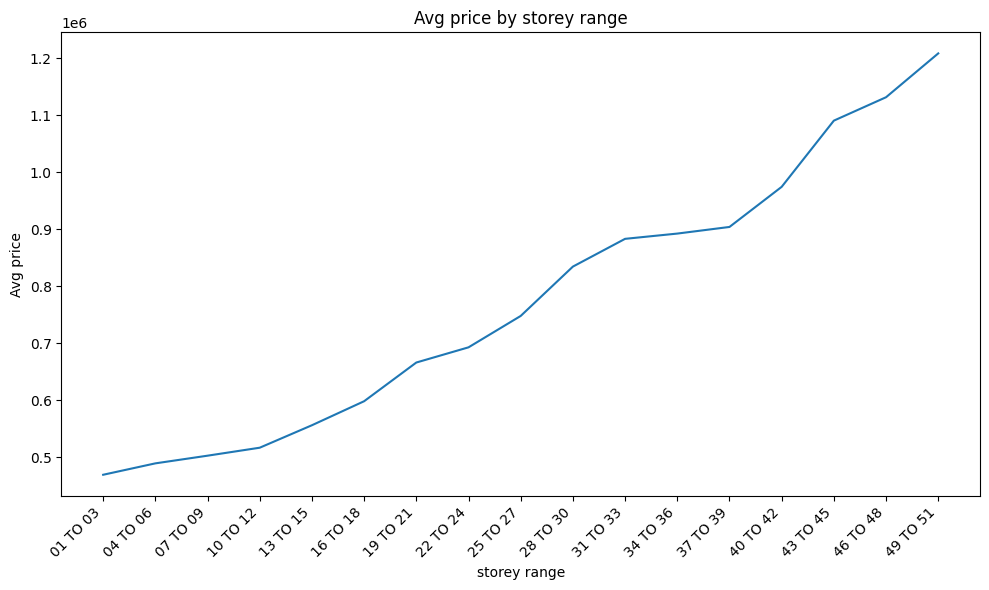

In [32]:
plt.figure(figsize=(10, 6))
plt.title("Avg price by storey range")
plt.plot(df.groupby('storey_range')['resale_price'].mean())
plt.xlabel("storey range")
plt.ylabel("Avg price")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Height Premium Confirmed:
Clear upward trend showing Singaporeans pay premiums for higher floors, likely due to:
- Better views and air circulation
- Reduced noise from street level  
- Prestige factor in high-density living

**Model Feature:** Storey range will be an important categorical feature, with clear ordinal relationships our embeddings should capture.

## Remaining Lease Analysis - The Critical Factor
In Singapore's leasehold system, remaining lease duration should be the strongest price predictor. Let's investigate this crucial relationship.

In [33]:
print(df['remaining_lease'].head(10))
print("Unique formats:", df['remaining_lease'].nunique())

0    61 years 04 months
1    60 years 07 months
2    62 years 05 months
3     62 years 01 month
4    62 years 05 months
5              63 years
6    61 years 06 months
7    58 years 04 months
8    61 years 06 months
9    61 years 04 months
Name: remaining_lease, dtype: object
Unique formats: 691


In [34]:
def convert_to_months(text):
  text = text.split()
  months = 0
  for i,word in enumerate(text):
    if word in ["years", "year"]:
      months += int(text[i-1])*12
    elif word in ["months", "month"]:
      months += int(text[i-1])
  return months


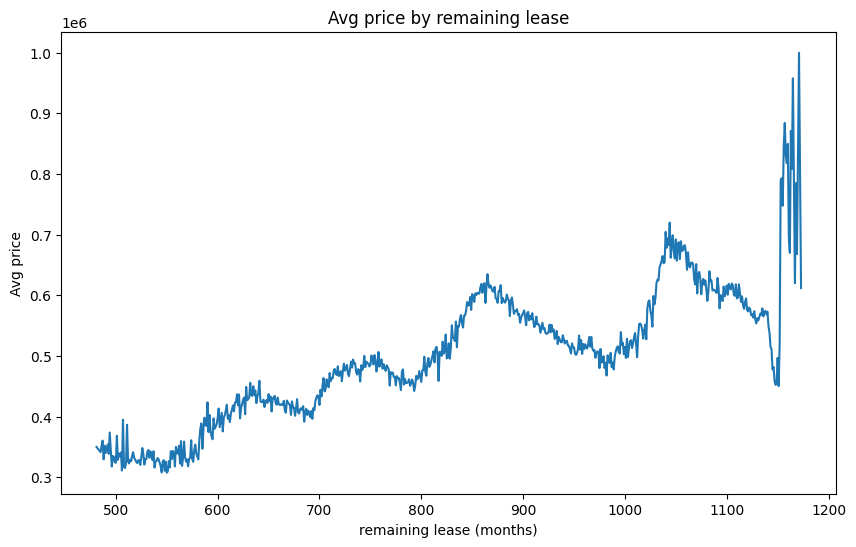

In [38]:
plt.figure(figsize=(10, 6))
plt.title("Avg price by remaining lease")
df['remaining_lease_months'] = df['remaining_lease'].apply(convert_to_months)
plt.plot(df.groupby('remaining_lease_months')['resale_price'].mean())
plt.xlabel("remaining lease (months)")
plt.ylabel("Avg price")
plt.show()

### Complex Lease-Price Dynamics Uncovered:

**Multi-Phase Relationship:** This fascinating pattern reveals distinct market behaviors:

- **450-700 months (37-58 years):** Steady appreciation - older flats with decent remaining value
- **700-900 months (58-75 years):** Volatile middle range with multiple peaks and dips
- **900-1100 months (75-92 years):** Premium established developments showing strong values
- **1100+ months (92+ years):** Dramatic price spikes for the newest developments

**Key Observations:**
- **Not simply linear:** Remaining lease doesn't follow simple depreciation
- **Market segmentation:** Different buyer pools operate at different lease ranges
- **Premium for newest:** The massive spike at 1150+ months shows buyers pay substantial premiums for maximum remaining lease

**Neural Network Advantage:** This complex non-linear relationship demonstrates why deep learning will capture patterns that linear models would miss.

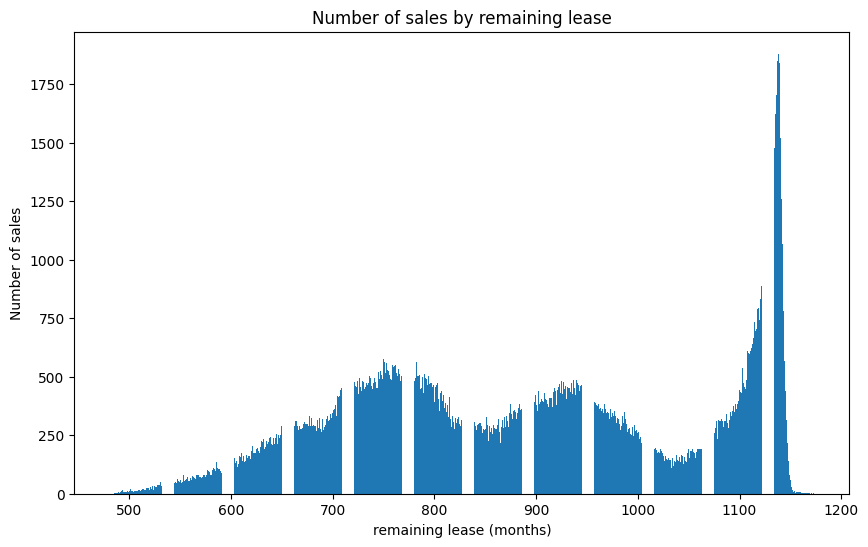

town        flat_type
ANG MO KIO  3 ROOM       47
            4 ROOM       26
            5 ROOM       12
BEDOK       2 ROOM        2
            3 ROOM       36
                         ..
WOODLANDS   5 ROOM        8
YISHUN      3 ROOM       44
            4 ROOM       35
            5 ROOM       13
            EXECUTIVE    11
Length: 95, dtype: int64

In [41]:
lease_counts = df['remaining_lease_months'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.title("Number of sales by remaining lease")
plt.bar(lease_counts.index,lease_counts.values)
plt.xlabel("remaining lease (months)")
plt.ylabel("Number of sales")
plt.show()
# See which towns/flat types cluster around these dips
df[df['remaining_lease_months'].isin([700, 800, 1000, 1150])].groupby(['town', 'flat_type']).size()

### Transaction Volume Distribution:

**Dramatic Volume Patterns:**
- **Massive peak at 1150-1200 months:** The highest transaction volume occurs for the newest flats with maximum remaining lease
- **Secondary peaks around 700-800 and 900-950 months:** Show active markets in middle-aged developments
- **Gradual build-up from 600-1100 months:** Steady transaction activity across mature developments
- **Low volume below 600 months:** Very old flats with short leases see limited market activity

**Market Structure Insights:**
- **New development surge:** The enormous spike at 1150+ months indicates major recent construction activity or bulk sales from new projects
- **Financing accessibility:** Higher volumes at longer lease lengths suggest easier financing/CPF usage for flats with substantial remaining lease
- **Investment preference:** Buyers clearly prefer flats with maximum remaining value

**Modeling Implications:**
- **Rich training data at extremes:** Abundant data for both newest (1150+ months) and established (700-950 months) categories
- **Potential data imbalance:** The massive volume spike at newest flats may require careful sampling or weighting strategies
- **Real market dynamics:** This distribution reflects actual buyer preferences, not data artifacts

**Business Insight:** The volume concentration at maximum lease lengths suggests Singapore's resale market is heavily driven by new project completions and buyers' preference for maximum remaining lease value.

## Analysis Summary & Modeling Readiness

This comprehensive exploration reveals a sophisticated dataset ideal for neural network modeling:

**Key Predictive Features Identified:**
- **Location hierarchy** (26 towns showing clear price differentials)
- **Property characteristics** (flat_type showing logical price progression, floor_area with positive correlation)
- **Temporal dynamics** (newer buildings commanding premiums, market cycles evident)
- **Complex lease relationships** (non-linear remaining lease effects with multiple market segments)
- **Height premiums** (higher floors commanding higher prices)

**Neural Network Justification:**
The non-linear relationships, categorical hierarchies, and complex interactions we've discovered validate our PyTorch approach over traditional linear models.

**Next Steps:** Ready to build preprocessing pipeline and neural network architecture to capture these sophisticated market dynamics.